In [16]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADCLOUD_MODEL_STATE_DICT_PATH=os.getenv("RADCLOUD_MODEL_STATE_DICT_PATH")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radcloud_encoder import RadCloudEncoder
from mmwave_model_integrator.model_runner.radcloud_runner import RadCloudRunner
from mmwave_model_integrator.decoders.radcloud_decoder import RadCloudDecoder
from mmwave_model_integrator.ground_truth_encoders.radcloud_gt_encoder import RadCloudGTEncoder
from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.plotting.movies_rng_az_to_pc import MovieGeneratorRngAzToPC
from mmwave_model_integrator.analyzers.analyzer_rng_az_to_pc import AnalyzerRngAzToPC
from mmwave_model_integrator.transforms.coordinate_transforms import polar_to_cartesian


In [17]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadCloud.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [18]:
#load the dataset
dataset_folder = "WILK"
dataset_name = "WILK_1"
radcloud_dataset_path = "/data/radnav"
dataset_path = os.path.join(radcloud_dataset_path,"radCloud_comp_datasets",dataset_folder,dataset_name)
print(dataset_path)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

/data/radnav/radCloud_comp_datasets/WILK/WILK_1
found 1101 radar samples
found 1101 lidar samples
found 1101 camera samples
found 1101 imu (orientation only) samples
found 1101imu (full data) samples
found 1101 vehicle velocity samples


In [19]:
plotter = PlotterRngAzToPC()

input_encoder = RadCloudEncoder(
    config_manager=cfg_manager,
    max_range_bin=64,
    num_chirps_to_encode=40,
    radar_fov_rad= [-0.87,0.87],
    num_az_angle_bins=64,
    power_range_dB=[60,105]
)

ground_truth_encoder = RadCloudGTEncoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(50),np.deg2rad(-50)],#[-np.pi/2 - 0.87,-np.pi/2 + 0.87],
    num_angle_bins=48,
    num_previous_frames=0
)

runner = RadCloudRunner(
    state_dict_path=RADCLOUD_MODEL_STATE_DICT_PATH,
    cuda_device="cpu"
)


prediction_decoder = RadCloudDecoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(50),np.deg2rad(-50)],#[-np.pi/2 - 0.87,-np.pi/2 + 0.87],
    num_angle_bins=48
)

movie_generator = MovieGeneratorRngAzToPC(
    cpsl_dataset=dataset,
    plotter=plotter,
    input_encoder=input_encoder,
    runner=runner,
    decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("MOVIE_TEMP_DIRECTORY")
)

analyzer = AnalyzerRngAzToPC(
    cpsl_dataset=dataset,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("ANALYZER_TEMP_DIRECTORY")
)

_ModelRunner: using CPU
Total number of parameters: 7724289
found temp dir: /home/david/Downloads/radnav_temp_dir
clearing temp directory /home/david/Downloads/radnav_temp_dir


In [14]:
#evaluating the model on standard inputs
adc_cube = dataset.get_radar_data(idx=0)
rng_az_resp = input_encoder.encode(adc_cube)
pred = runner.make_prediction(input=rng_az_resp)
pc = prediction_decoder.convert_polar_to_cartesian(
    prediction_decoder.decode(pred)
)

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx=0)
grid = ground_truth_encoder.encode(lidar_pc)
quantized_pc = ground_truth_encoder.grid_to_polar_points(grid)
quantized_pc = polar_to_cartesian(quantized_pc)

In [13]:
plotter.plot_compilation(
    input_data=adc_cube,
    input_encoder=input_encoder,
    runner=runner,
    decoder=prediction_decoder,
    gt_data=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    axs=[],
    show=True
)

NameError: name 'adc_cube' is not defined

In [20]:
#speed comparison
from tqdm import tqdm

for i in tqdm(range(dataset.num_frames)):

    adc_cube = dataset.get_radar_data(idx=1)
    rng_az_resp = input_encoder.encode(adc_cube)
    pred = runner.make_prediction(input=rng_az_resp)
    pc = prediction_decoder.convert_polar_to_cartesian(
        prediction_decoder.decode(pred)
    )

100%|██████████| 1101/1101 [00:20<00:00, 53.83it/s]


In [7]:
chamfer,hausdorff, chamfer_radarHD, modified_hausdorff_radarHD = \
    analyzer.compute_all_distance_metrics(
        save_to_file=True,
        file_name=dataset_name
    )
analyzer.show_all_summary_statistics(
    chamfer_distances=chamfer,
    hausdorff_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorff_distances_radarHD=modified_hausdorff_radarHD
)

Analyzer.compute_all_distance_metrics: Computing distance metrics


100%|██████████| 1100/1100 [00:09<00:00, 113.47it/s]

Analyzer.compute_all_distance_metrics: number failed predictoins 0 of 1100 (0.0%)


,Metric,Hausdorff,Modified Hausdorff (radarHD),Chamfer,Chamfer (radarHD)
0,Mean,2.733571,0.415462,1.308294,0.427373
1,Median,2.449892,0.282016,0.788197,0.380721
2,90th percentile,4.527691,0.982096,3.292108,0.761741


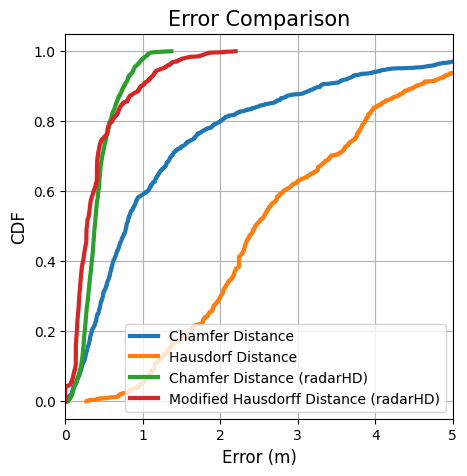

In [8]:
plotter.plot_distance_metrics_cdfs(
    chamfer_distances=chamfer,
    hausdorf_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorf_distances_radarHD=modified_hausdorff_radarHD
)

100%|██████████| 1100/1100 [01:12<00:00, 15.07it/s]


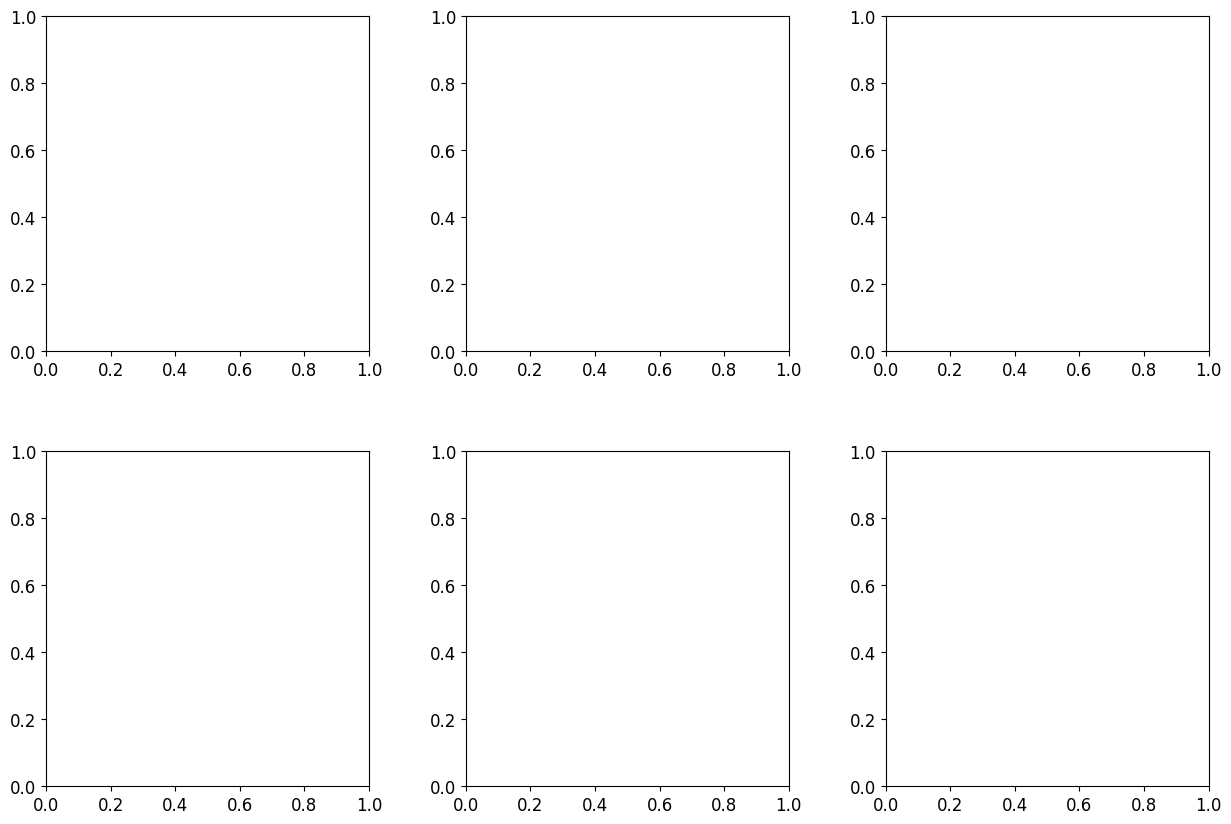

In [9]:
movie_generator.initialize_figure(
    nrows=2,
    ncols=3,
    figsize=(15,10),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}.mp4".format(dataset_name),fps=fps)